# Meteorite Landings Analysis
### Can we predict where the next likely impact zone will be with the information given ? 

In [25]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import datetime
import os

#### Loading the dataset 

In [26]:
# Load dataset into a dataframe
data = pd.read_csv("Meteorite_Landings.csv")

# Printing the shape of the dataset before cleaning
print("Initial Data Shape:", data.shape)

# Display the first few rows
print("Initial Data Preview:")
data.head()

Initial Data Shape: (45716, 11)
Initial Data Preview:


,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,Unnamed: 10
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)",NaN
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)",NaN
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)",NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)",NaN
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)",NaN


### Displaying the Basic Information about the dataset

In [27]:
# Display basic information about the dataset such as the columns, data types, and number of rows
print("Initial Data Information:")
print(data.info())

Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
 10  Unnamed: 10  0 non-null      float64
dtypes: float64(5), int64(1), object(5)
memory usage: 3.8+ MB
None


In [28]:
# Show summary statistics for numeric columns in the dataset
print("Summary Statistics:")
print(data.describe())

Summary Statistics:
                 id      mass (g)          year        reclat       reclong  \
count  45716.000000  4.558500e+04  45425.000000  38401.000000  38401.000000   
mean   26889.735104  1.327808e+04   1991.828817    -39.122580     61.074319   
std    16860.683030  5.749889e+05     25.052766     46.378511     80.647298   
min        1.000000  0.000000e+00    860.000000    -87.366670   -165.433330   
25%    12688.750000  7.200000e+00   1987.000000    -76.714240      0.000000   
50%    24261.500000  3.260000e+01   1998.000000    -71.500000     35.666670   
75%    40656.750000  2.026000e+02   2003.000000      0.000000    157.166670   
max    57458.000000  6.000000e+07   2101.000000     81.166670    354.473330   

       Unnamed: 10  
count          0.0  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN  


#### Identifying Missing Values in the Dataset and Filling in the blanks or dropping them for convinience

In [29]:
# Display the number of missing values in each column of the dataset
print("Missing Values Before Cleaning:")
print(data.isnull().sum())

Missing Values Before Cleaning:
name               0
id                 0
nametype           0
recclass           0
mass (g)         131
fall               0
year             291
reclat          7315
reclong         7315
GeoLocation     7315
Unnamed: 10    45716
dtype: int64


In [30]:
# Drop columns that are not needed
data.drop(columns=['Unnamed: 10', 'GeoLocation'], inplace=True, errors='ignore')

# Rename 'mass (g)' to 'mass' for convenience
data.rename(columns={'mass (g)': 'mass'}, inplace=True)

# Drop rows where reclat or reclong is missing
data.dropna(subset=['reclat', 'reclong'], inplace=True)


In [31]:
# Convert 'year' to datetime format and extract the year
data['year'] = pd.to_datetime(data['year'], errors='coerce').dt.year

# Fill missing year values with the median year
data['year'].fillna(int(data['year'].median()), inplace=True)

# Fill missing mass values with the median mass
data['mass'].fillna(data['mass'].median(), inplace=True)

/var/folders/f3/rfrtm_1x3jdcbvthtx6cdxfc0000gn/T/ipykernel_11461/335241860.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['year'].fillna(int(data['year'].median()), inplace=True)
/var/folders/f3/rfrtm_1x3jdcbvthtx6cdxfc0000gn/T/ipykernel_11461/335241860.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [32]:
# Creating a new column 'log-transformed mass' to handle the skewness in the mass column
data['log_mass'] = np.log1p(data['mass'])

In [33]:
# Display the number of missing values in each column of the dataset after cleaning
print("Remaining Missing Values:")
print(data.isnull().sum())

# Print the shape of the cleaned dataset
print("\nData Shape After Cleaning:", data.shape)
data.head()


Remaining Missing Values:
name        0
id          0
nametype    0
recclass    0
mass        0
fall        0
year        0
reclat      0
reclong     0
log_mass    0
dtype: int64

Data Shape After Cleaning: (38401, 10)


,name,id,nametype,recclass,mass,fall,year,reclat,reclong,log_mass
0,Aachen,1,Valid,L5,21.0,Fell,1970.0,50.77500,6.08333,3.091042
1,Aarhus,2,Valid,H6,720.0,Fell,1970.0,56.18333,10.23333,6.580639
2,Abee,6,Valid,EH4,107000.0,Fell,1970.0,54.21667,-113.00000,11.580593
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1970.0,16.88333,-99.90000,7.557473
4,Achiras,370,Valid,L6,780.0,Fell,1970.0,-33.16667,-64.95000,6.660575


In [34]:
# Type of features in the dataset
continuous_features = ['log_mass', 'year', 'reclat', 'reclong']
categorical_features = ['fall', 'nametype', 'recclass']

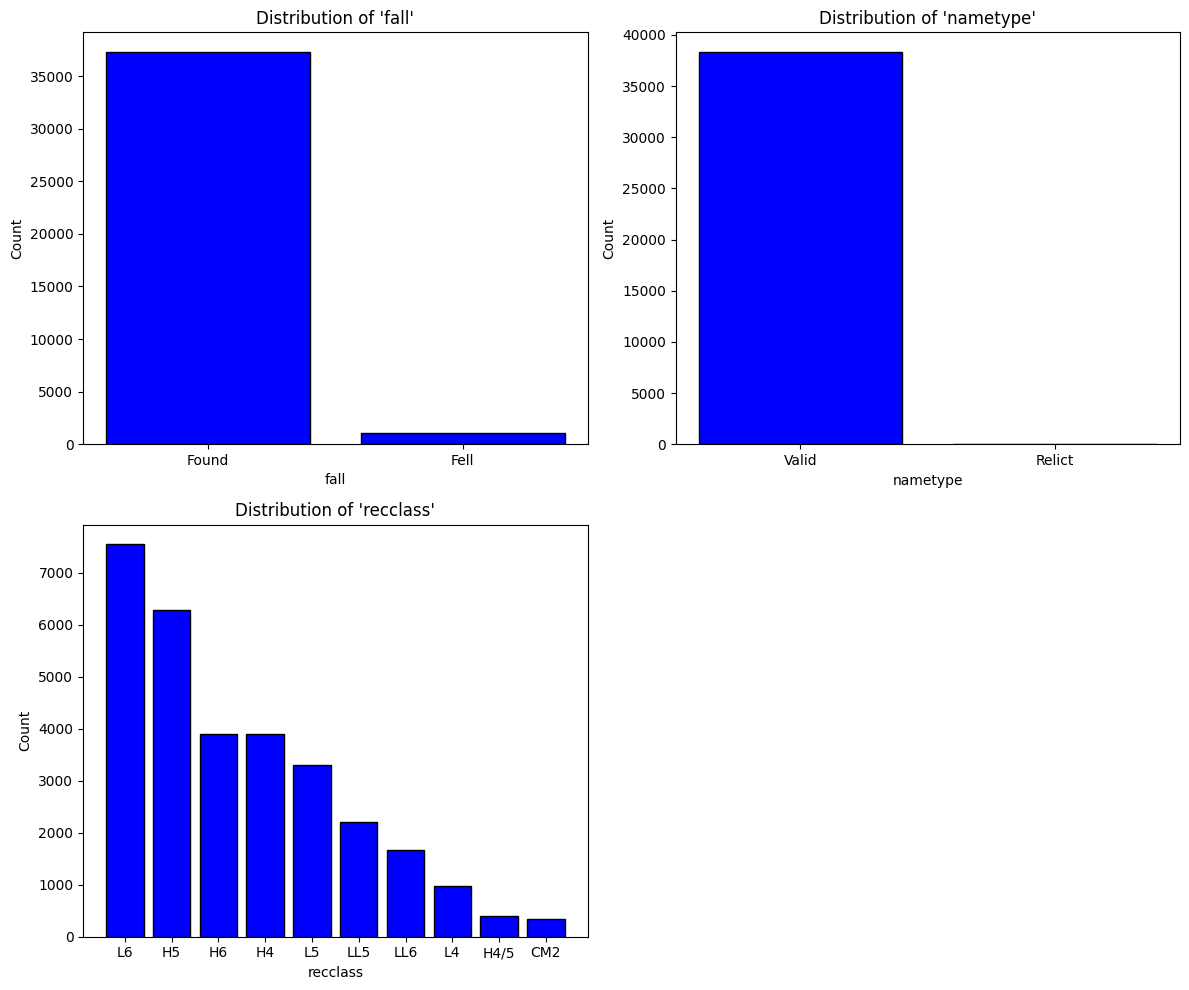

In [35]:
# Plotting the distribution of categorical features
plt.figure(figsize=(12, 10))
for cat_col in categorical_features:
    # Count the occurrences of each category
    value_counts = data[cat_col].value_counts()
    
    # Since 'recclass' has too many categories, we will limit it to the top 10
    value_counts = value_counts.head(10)
    
    # Plot the distribution of the categorical column
    plt.subplot(2, 2, categorical_features.index(cat_col)+1)
    plt.bar(value_counts.index, value_counts.values, color='blue', edgecolor='black')
    plt.title(f"Distribution of '{cat_col}'")
    plt.xlabel(cat_col)
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


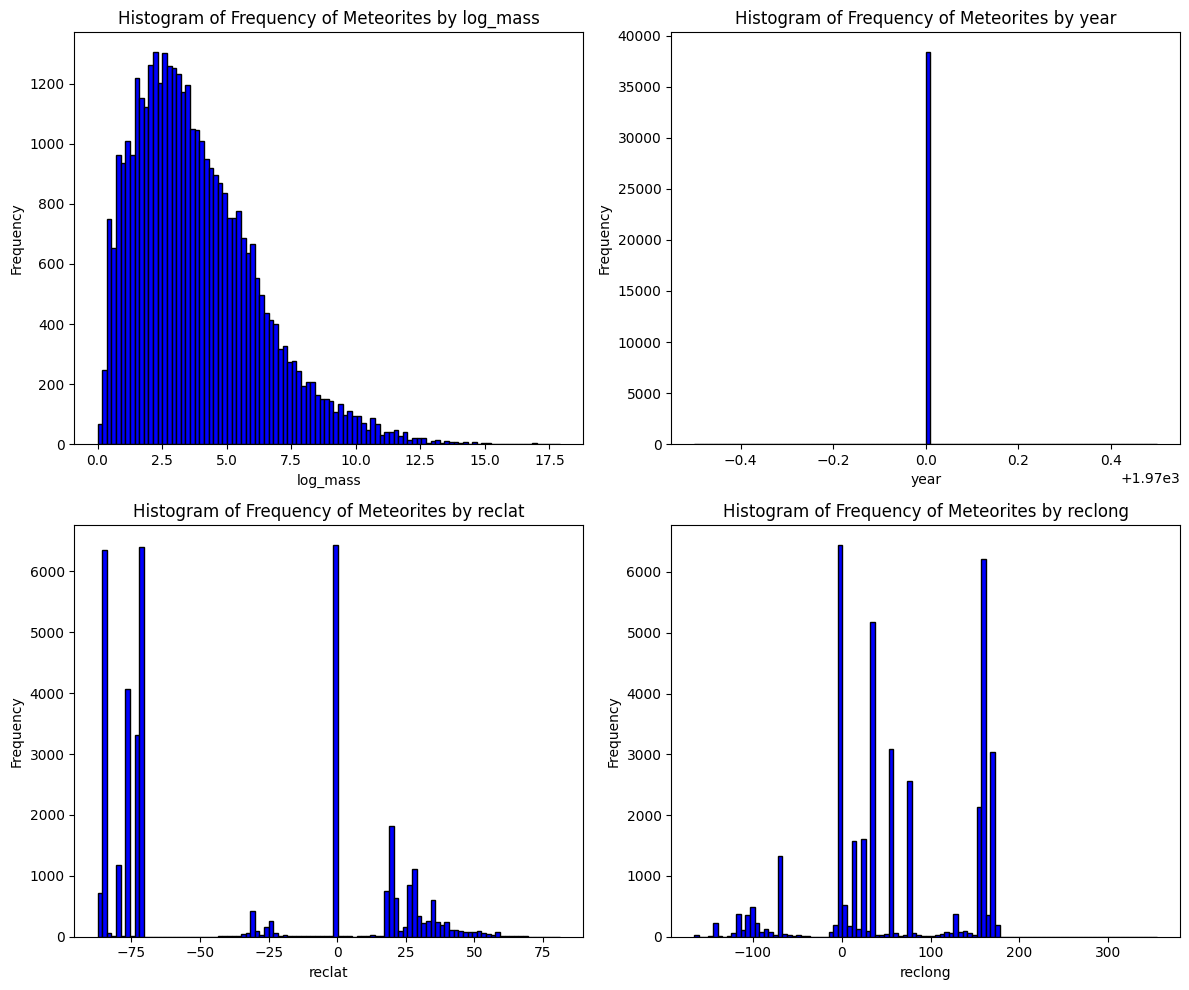

In [36]:
# Plotting histograms of continuous features
plt.figure(figsize=(12, 10))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    plt.hist(data[col], bins=100, color='blue', edgecolor='black')
    plt.title(f"Histogram of Frequency of Meteorites by {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Fix year values

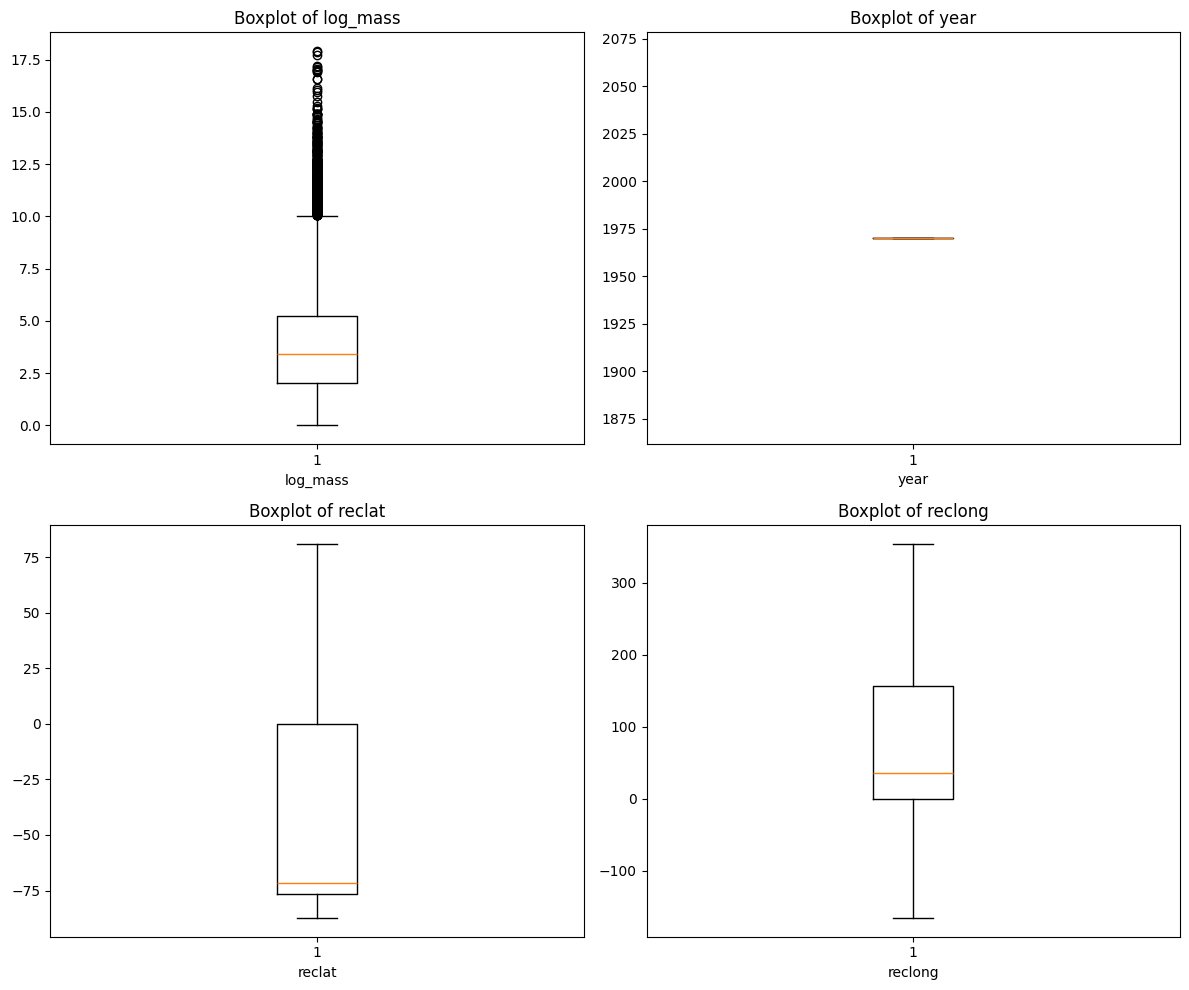

In [37]:
# Plotting boxplots of continuous features
plt.figure(figsize=(12, 10))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    plt.boxplot(data[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

## TODO: Add the Cat v Cat, Con v Cat, Con v Con

In [38]:
# Heatmap of where meteorites have fallen on like the map

# Heatmap reclat vs reclong to show where meteorites have fallen

# Do range for geolocation (reclat, reclong) vs mass, recclass
# If mass or recclass matter for where it lands

# Fix Year values (Histogram of year)

# Fell --> graph to compare fell with year
# Found --> graph to compare found with year



## Scatter Plots

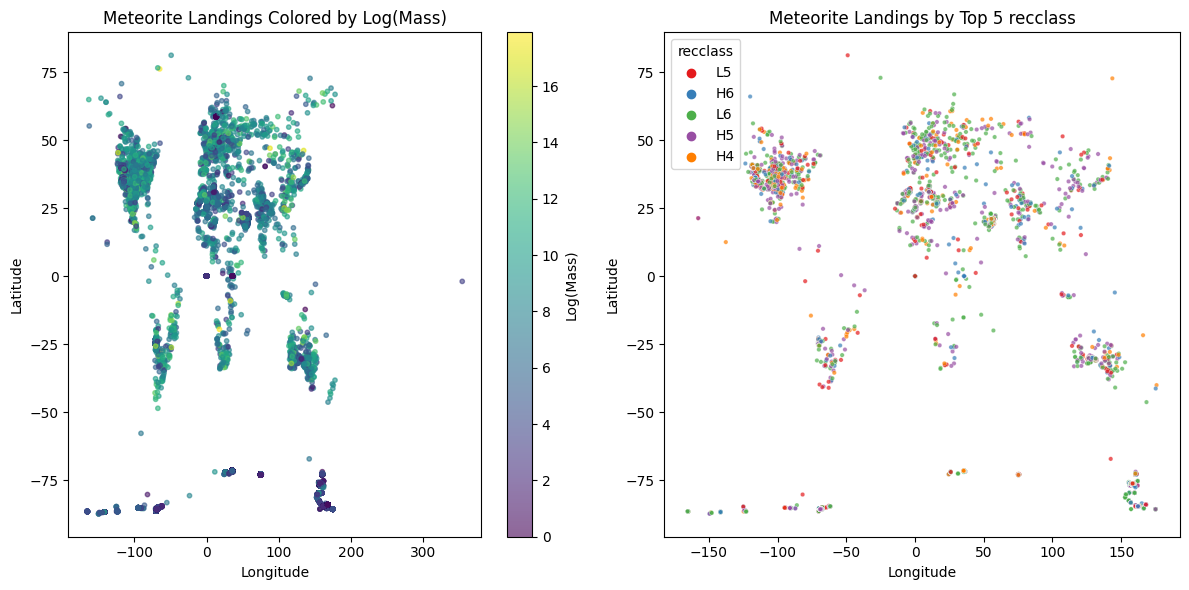

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of reclat vs reclong colored by log_mass
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sc = plt.scatter(data['reclong'], data['reclat'], c=data['log_mass'], cmap='viridis', s=10, alpha=0.6)
plt.colorbar(sc, label='Log(Mass)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Meteorite Landings Colored by Log(Mass)')

# Filter the top 5 recclass for better visualization
top_classes = data['recclass'].value_counts().head(5).index
filtered_data = data[data['recclass'].isin(top_classes)]

# Scatter plot of reclat vs reclong colored by recclass
plt.subplot(1, 2, 2)
sns.scatterplot(data=filtered_data, x='reclong', y='reclat', hue='recclass', palette='Set1', s=10, alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Meteorite Landings by Top 5 recclass')
plt.legend(title='recclass')

plt.tight_layout()
plt.show()


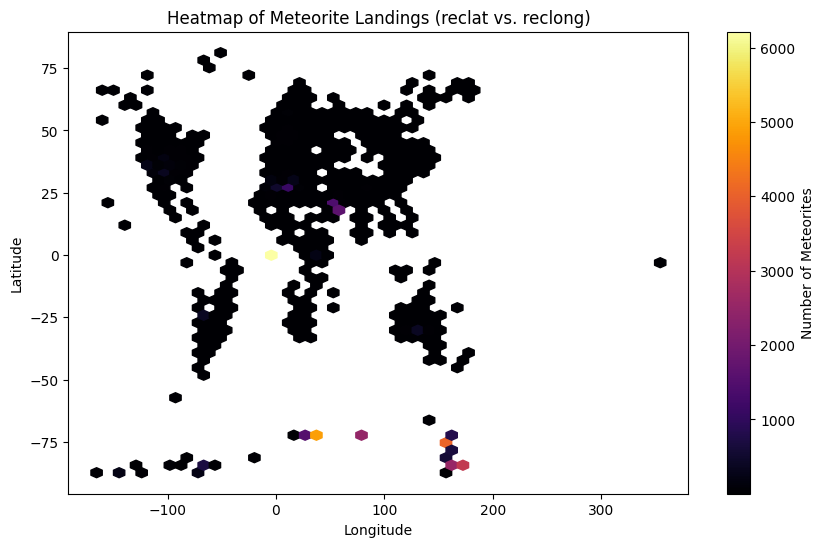

In [40]:
# Heatmap of meteorite landings (reclat vs. reclong)
plt.figure(figsize=(10, 6))
hb = plt.hexbin(data['reclong'], data['reclat'], gridsize=50, cmap='inferno', mincnt=1)
cb = plt.colorbar(hb)
cb.set_label('Number of Meteorites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Meteorite Landings (reclat vs. reclong)')
plt.show()

In [49]:
# Landings of meteorites on a map
import folium
from folium.plugins import HeatMap

map_center = [data['reclat'].mean(), data['reclong'].mean()]

# Create a base map
meteorite_map = folium.Map(location=map_center, zoom_start=2)

heat_data = [[row['reclat'], row['reclong']] for index, row in data.iterrows()]

# Add the heatmap layer to the base map
HeatMap(heat_data, radius=8, blur=15).add_to(meteorite_map)

# Display the map 
display(meteorite_map)


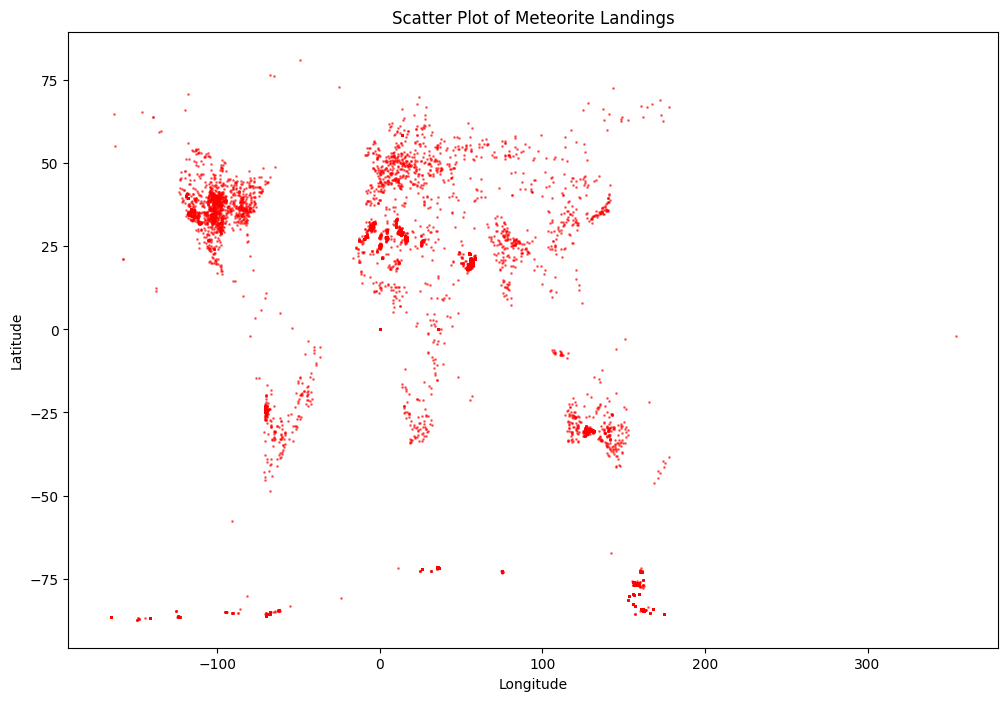

In [ ]:
# Plotting the scatter plot of meteorite landings
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(data['reclong'], data['reclat'], s=1, c='red', alpha=0.5)
plt.title("Scatter Plot of Meteorite Landings")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Split the Data for Training

In [43]:
# Define feature set X and target variables y (assuming 'reclat' and 'reclong' are targets)
# X = data[['log_mass', 'year', 'recclass', 'fall', 'nametype']]
X = data[['log_mass', 'year', 'recclass']]
y = data[['reclat', 'reclong']]

# Convert categorical features to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (30720, 428) (30720, 2)
Testing set shape: (7681, 428) (7681, 2)


## Training the Models

In [44]:
# Define hyperparameters for Random Forest Regressor
rf_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
}

# Define hyperparameters for XGBoost Regressor
xgb_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.1, 0.01, 0.001],
    'estimator__subsample': [0.8, 1.0]
}

In [45]:
# Set up KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate a model
def evaluate_model(model, X, y, param_grid, model_name):
    # Use GridSearchCV with negative MSE as scoring (n_jobs=-1 uses all processors)
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=1)
    grid_search.fit(X, y)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # Evaluate using K-Fold Cross Validation
    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_idx, val_idx in kfold.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Predict using the best model
        y_pred = best_model.predict(X_val_fold)

        # Calculate metrics
        mse_scores.append(mean_squared_error(y_val_fold, y_pred))
        mae_scores.append(mean_absolute_error(y_val_fold, y_pred))
        r2_scores.append(r2_score(y_val_fold, y_pred))

    # Average Scores for K-Fold
    print(f"{model_name} - Average MSE: {np.mean(mse_scores):.4f}, "
          f"MAE: {np.mean(mae_scores):.4f}, R²: {np.mean(r2_scores):.4f}")

    return best_model

In [46]:
# Check if the saved models exist
if os.path.exists('best_rf_model.pkl') and os.path.exists('best_xgb_model.pkl'):
    print("Model exists, loading from disk.")
    print("Loading existing models...")
    with open('best_rf_model.pkl', 'rb') as f:
        best_rf_model = pickle.load(f)
    with open('best_xgb_model.pkl', 'rb') as f:
        best_xgb_model = pickle.load(f)

else:

    print("Model does not exist, training new models.")
    # For Random Forest
    rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    best_rf_model = evaluate_model(rf_model, X_train, y_train, rf_param_grid, 'Random Forest')

    # For XGBoost
    xgb_model = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
    best_xgb_model = evaluate_model(xgb_model, X_train, y_train, xgb_param_grid, 'XGBoost')

    # Save the best models
    pickle.dump(best_rf_model, open('best_rf_model.pkl', 'wb'))
    pickle.dump(best_xgb_model, open('best_xgb_model.pkl', 'wb'))

Model exists, loading from disk.
Loading existing models...


## Displaying Results of the Models

In [47]:
print("\n--- Final Evaluation on Test Set ---")
rf_y_pred = best_rf_model.predict(X_test)
print("Random Forest Test Set Metrics:")
print(f"MSE: {mean_squared_error(y_test, rf_y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, rf_y_pred):.4f}")
print(f"R²: {r2_score(y_test, rf_y_pred):.4f}")

xgb_y_pred = best_xgb_model.predict(X_test)
print("\nXGBoost Test Set Metrics:")
print(f"MSE: {mean_squared_error(y_test, xgb_y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, xgb_y_pred):.4f}")
print(f"R²: {r2_score(y_test, xgb_y_pred):.4f}")


--- Final Evaluation on Test Set ---
Random Forest Test Set Metrics:
MSE: 3525.9199
MAE: 46.2133
R²: 0.2347

XGBoost Test Set Metrics:
MSE: 3446.8801
MAE: 45.6787
R²: 0.2539
